# Exploring Dandiset 001366: Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification

**Notebook generated with the assistance of AI. Please review and interpret code/results with caution.**

This notebook introduces [Dandiset 001366](https://dandiarchive.org/dandiset/001366/0.250324.1603), which contains time-series imaging data from mouse pial vessels, acquired to compare vessel diameter and pulsatility analysis methods. The data are provided as NWB files.

## Notebook Overview
In this notebook, you will:

- Learn about the contents and structure of Dandiset 001366.
- Use the DANDI API to explore included NWB assets.
- Stream and visualize image data directly from the archive.
- Extract basic time series and vessel diameters using FWHM on example frames.
- Compare the two NWB files in the Dandiset.

**Required packages:**  
- dandi  
- pynwb  
- h5py  
- remfile  
- numpy  
- matplotlib  
- scipy

## 1. Overview of Dandiset 001366

- **Title:** Comparison of Approaches for Surface Vessel Diameter and Pulsatility Quantification
- **DOI:** [10.48324/dandi.001366/0.250324.1603](https://dandiarchive.org/dandiset/001366/0.250324.1603)
- **Contents:** Movies (time-series image data) of mouse pial vessels, for comparing analysis techniques.
- **Format:** Neurodata Without Borders (NWB)
- **Subjects:** 2 mice, 2 NWB files
- **Keywords:** vessel diameter, vessel pulsation, image analysis, full width at half maximum, radon transform

## 2. List Required Packages

The following packages are required to run this notebook:  
`dandi`, `pynwb`, `h5py`, `remfile`, `numpy`, `matplotlib`, `scipy`

(Assumed already installed.)

## 3. Explore Dandiset Assets with the DANDI API

In [1]:
from dandi.dandiapi import DandiAPIClient

# Connect to the DANDI archive
dandiset_id = "001366"
dandiset_version = "0.250324.1603"
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset_paths = [a.path for a in dandiset.get_assets()]
    print("Assets in Dandiset 001366:")
    for path in asset_paths:
        print("-", path)

Assets in Dandiset 001366:
- sub-F15/sub-F15_ses-F15BC-19102023_image.nwb
- sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb


The two main NWB files in the Dandiset are:

1. `sub-F15/sub-F15_ses-F15BC-19102023_image.nwb`
2. `sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb`

## 4. Visualize the First Frame from "sub-F15/sub-F15_ses-F15BC-19102023_image.nwb"

This NWB file contains a single 16-bit grayscale ImageSeries ("Movies") of shape (9553, 214, 132).

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


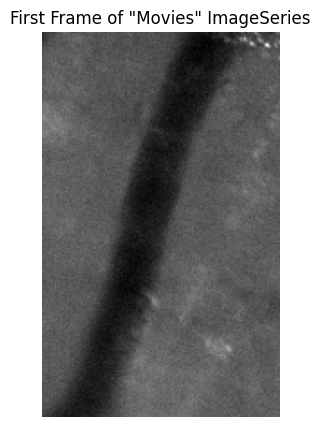

In [2]:
import pynwb
import h5py
import remfile
import matplotlib.pyplot as plt

# Get the download URL for the asset
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob("sub-F15/sub-F15_ses-F15BC-19102023_image.nwb"))
    url = asset.download_url

# Stream the NWB file and open it with pynwb
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Access the "Movies" ImageSeries and display the first frame
movies = nwb.acquisition['Movies']
frame0 = movies.data[0, :, :]

plt.figure(figsize=(4, 5))
plt.imshow(frame0, cmap='gray')
plt.title('First Frame of "Movies" ImageSeries')
plt.axis('off')
plt.show()

## 5. Plot the Time Series of Average Pixel Intensity (First 500 Frames)

We compute the average intensity across all pixels in each of the first 500 frames and plot the resulting time series.

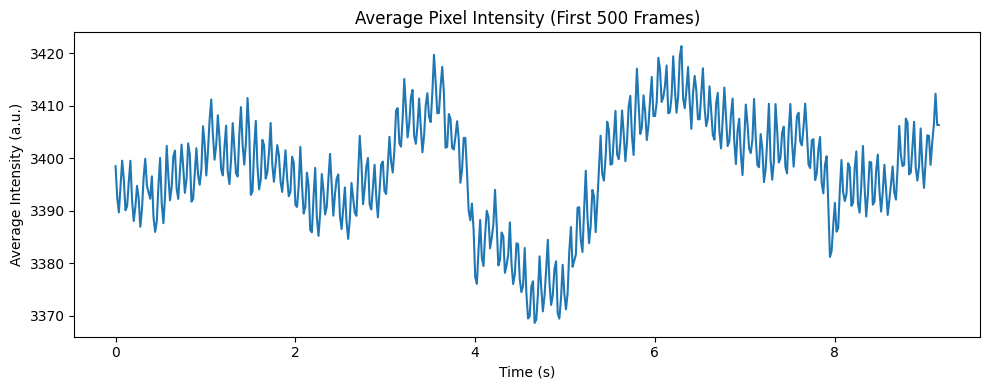

In [3]:
import numpy as np

# Extract first 500 frames
frames = movies.data[0:500, :, :]
avg_intensity = frames.mean(axis=(1,2))

# Create time axis using the frame rate from the NWB metadata
frame_rate = movies.rate
frame_times = np.arange(500) / frame_rate

plt.figure(figsize=(10, 4))
plt.plot(frame_times, avg_intensity)
plt.xlabel('Time (s)')
plt.ylabel('Average Intensity (a.u.)')
plt.title('Average Pixel Intensity (First 500 Frames)')
plt.tight_layout()
plt.show()

## 6. Extract and Plot Vessel Diameter Using FWHM (First Frame)

We extract a horizontal cross-section from the center of the vessel image, invert the intensities (since the vessel appears dark), and compute the Full Width at Half Maximum (FWHM) to estimate vessel diameter.

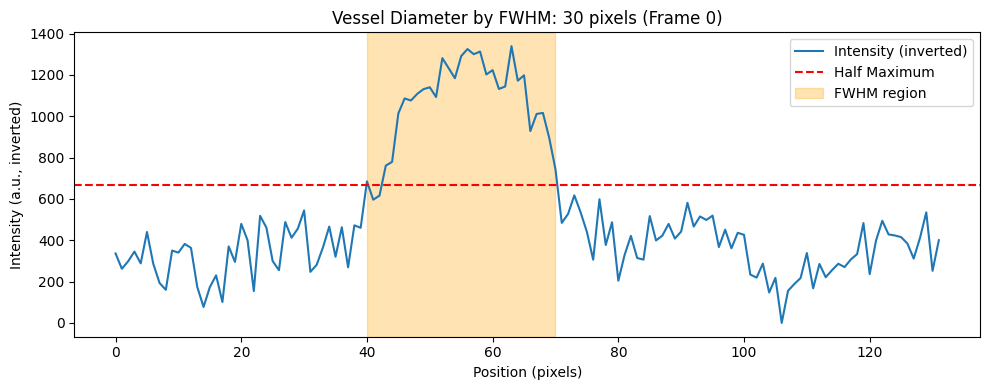

In [4]:
from scipy.signal import find_peaks

# Select a central row
row = frame0.shape[0] // 2
cross_section = frame0[row, :]

# Invert if the vessel is dark
inverted = np.max(cross_section) - cross_section

# Compute FWHM
half_max = (np.max(inverted) + np.min(inverted)) / 2
above_half = inverted > half_max
indices = np.where(above_half)[0]
if len(indices) > 1:
    fwhm_left = indices[0]
    fwhm_right = indices[-1]
    diameter_pixels = fwhm_right - fwhm_left
else:
    diameter_pixels = 0

# Visualization
plt.figure(figsize=(10, 4))
plt.plot(inverted, label='Intensity (inverted)')
plt.axhline(half_max, color='r', linestyle='--', label='Half Maximum')
plt.axvspan(fwhm_left, fwhm_right, color='orange', alpha=0.3, label='FWHM region')
plt.xlabel('Position (pixels)')
plt.ylabel('Intensity (a.u., inverted)')
plt.title(f'Vessel Diameter by FWHM: {diameter_pixels} pixels (Frame 0)')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Compare with the Second NWB File: "sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb"

This file contains a similar "Movies" ImageSeries, but with different shape, frame rate, and mouse metadata.

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


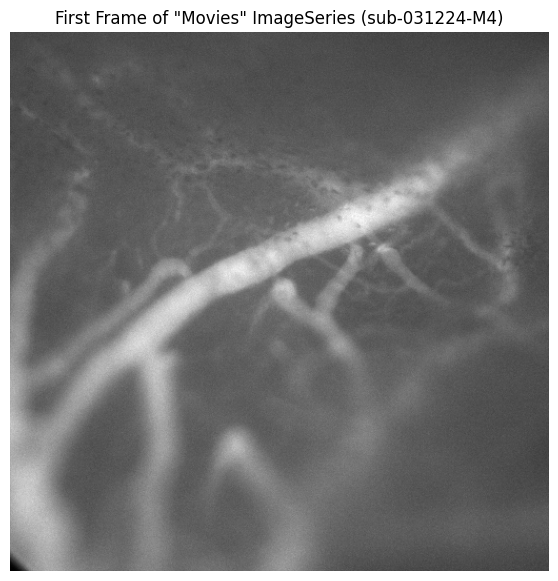

In [5]:
# Get the download URL for the second NWB file
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob("sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb"))
    url2 = asset.download_url

# Stream and load the second NWB file
remote_file2 = remfile.File(url2)
h5_file2 = h5py.File(remote_file2)
io2 = pynwb.NWBHDF5IO(file=h5_file2, load_namespaces=True)
nwb2 = io2.read()

# Access the "Movies" ImageSeries in this file and display the first frame
movies2 = nwb2.acquisition['Movies']
frame0_2 = movies2.data[0, :, :]

plt.figure(figsize=(7, 7))
plt.imshow(frame0_2, cmap='gray')
plt.title('First Frame of "Movies" ImageSeries (sub-031224-M4)')
plt.axis('off')
plt.show()

## 8. Summary

- Dandiset 001366 provides high-quality time series imaging data of mouse pial vessels for vessel diameter quantification studies.
- Both NWB files in this Dandiset have a similar structure: a single "Movies" ImageSeries with rich metadata.
- This notebook demonstrates how to explore file contents, visualize image data, calculate average intensities, and extract vessel diameter using the FWHM method—all by streaming data directly from the archive.

If you plan to perform further vessel analysis or automate processing, these code snippets provide a reproducible starting point for reanalysis on these and similar datasets.